# Gather and Assess
First, we load survey results from 2017, and then check the dataframe head to assess it

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import signal
from contextlib import contextmanager

df_17 = pd.read_csv('./survey_results_public_2017.csv')
df_17.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Clean and Analyze
Now, we clean the dataframe column, so we can use it in our model to predict salaries.

#### Timeout Function
There are some categorical columns with too much variation, what was making the function stall. So, I created this function to ignore those columns if it takes more than 5 seconds to create the respective dummies.

In [2]:
class TimeoutException(Exception): pass

@contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

#### Clean Function
Here is the clean function itself. The steps to clean the data, including treatment for numeric and categorical variables is described in the doc string inside the function.

In [3]:
def clean_data(df, year):
    '''
    INPUT
    df - pandas dataframe containing survey data
    year - year of the survey
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries, as it can't be used for prediction
    2. Create X as all the columns that are not the salary column
    3. Create y as the salary column
    4. Drop the Respondent comlumn, and the salary related columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column (a good method to work with missing values on numeric variables)
    6. Create dummy columns for all the categorical variables in X, drop the original columns (ignoring too complex multiple choice answers, as it would make the function stall)
    '''
    # Drop rows with missing salary values
    if (year==2017):
        df = df.dropna(subset=['Salary'], axis=0)
        y = df['Salary']
    elif (year==2018):
        df = df.dropna(subset=['ConvertedSalary'], axis=0)
        y = df['ConvertedSalary']
    elif (year==2019):
        df = df.dropna(subset=['ConvertedComp'], axis=0)
        y = df['ConvertedComp']
    else:
        print("Year option invalid")
        return [], []
    
    #Drop respondent and salary columns
    #Also CurrencySymbol, so it is not canceled with Currency and CurrencyDesc columns
    #In addition, drop JobContactPriorities, JobEmailPriorities and AssessJob columns because this ranking questions didn't work well with the model
    if (year==2017):
        df = df.drop(['Respondent'], axis=1)
        df = df[df.columns.drop(list(df.filter(regex='Salary')))]
    elif (year==2018):
        df = df.drop(['Respondent'], axis=1)
        df = df.drop(['CurrencySymbol'], axis=1)
        df = df.drop(df.filter(regex='JobContactPriorities').columns, axis=1)
        df = df.drop(df.filter(regex='JobEmailPriorities').columns, axis=1)
        df = df.drop(df.filter(regex='AssessJob').columns, axis=1)
        df = df[df.columns.drop(list(df.filter(regex='Salary')))]
    elif (year==2019):
        df = df.drop(['Respondent'], axis=1)
        df = df.drop(['CurrencySymbol'], axis=1)
        df = df[df.columns.drop(list(df.filter(regex='Comp')))]
    else:
        print("Year option invalid")
        return [], []
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables (a good method to work with this kind of variable)
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        df_reserve = df
        # just work with the categorical variables that don't take more than 5 seconds to add dummies, to not stall the function
        try:
            with time_limit(5):
                # for each cat add dummy var, drop original column
                df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
        # if the timeout is reached, we just drop the column, without adding dummies
        except TimeoutException as e:
            df = df_reserve.drop(var, axis=1)
    
    X = df
    return X, y

Then, we just use the function above to create X and y dataframes for 2017.

In [4]:
#Use the function to create X and y
X_17, y_17 = clean_data(df_17, 2017)
X_17.head()

,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,"ProgramHobby_Yes, I contribute to open source projects","ProgramHobby_Yes, I program as a hobby","ProgramHobby_Yes, both",Country_Albania,Country_Anguilla,Country_Argentina,...,QuestionsInteresting_Strongly agree,QuestionsInteresting_Strongly disagree,QuestionsConfusing_Disagree,QuestionsConfusing_Somewhat agree,QuestionsConfusing_Strongly agree,QuestionsConfusing_Strongly disagree,InterestedAnswers_Disagree,InterestedAnswers_Somewhat agree,InterestedAnswers_Strongly agree,InterestedAnswers_Strongly disagree
2,8.0,9.0,2.64292,8.000000,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
14,8.0,8.0,2.64292,8.000000,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
17,9.0,8.0,2.64292,8.000000,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
18,5.0,3.0,2.64292,8.511858,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,8.0,9.0,2.64292,8.000000,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# Model
Then, we finally create the LinearRegression model (as it is a good model to find the coefficient weight of each variable) to predict salaries, trying different cutoffs.

In [4]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    
    for cutoff in cutoffs:
        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])
        
        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)
        
        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)
        
        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)
        
    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()
    
    best_cutoff = max(results, key=results.get)
    
    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])
    
    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)
    
    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)
    
    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test, best_cutoff

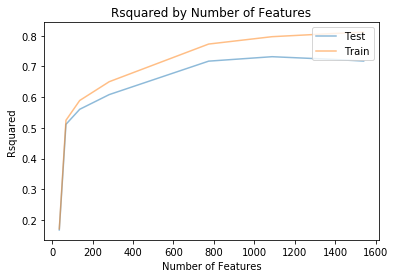

In [6]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

r2_scores_test_2017, r2_scores_train_2017, lm_model_2017, X_train_2017, X_test_2017, y_train_2017, y_test_2017, cutoff_2017 = find_optimal_lm_mod(X_17, y_17, cutoffs)

# Visualize
Finally, we get the weights of each coefficient in our model, so we can get to know what was more relevant to predict the salaries.

In [5]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = coefficients
    coefs_df['abs_coefs'] = np.abs(coefficients)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

In [10]:
#Use the function
coef_df_2017 = coef_weights(lm_model_2017.coef_, X_train_2017)

#A quick look at the top results
coef_df_2017.head(20)

,est_int,coefs,abs_coefs
42,Country_United States,56731.283619,56731.283619
28,Country_Norway,40550.628110,40550.628110
8,Country_Australia,40111.916279,40111.916279
383,Currency_Swiss francs,36748.955151,36748.955151
15,Country_Denmark,30497.628811,30497.628811
123,YearsCodedJob_20 or more years,29980.868555,29980.868555
27,Country_New Zealand,29954.315738,29954.315738
23,Country_Israel,29510.172957,29510.172957
13,Country_Canada,29363.254074,29363.254074
22,Country_Ireland,28551.627756,28551.627756


Here, we just repeat all the processes for 2018 data.

In [6]:
df_18 = pd.read_csv('./survey_results_public_2018.csv')
df_18.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,...,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,...,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy
1,3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,...,Daily or almost every day,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy
2,4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,...,I don't typically exercise,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,35 - 44 years old,No,No,The survey was an appropriate length,Somewhat easy
4,7,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,...,3 - 4 times per week,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,18 - 24 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy


In [7]:
#Use the function to create X and y
X_18, y_18 = clean_data(df_18, 2018)
X_18.head()

,AssessBenefits1,AssessBenefits2,AssessBenefits3,AssessBenefits4,AssessBenefits5,AssessBenefits6,AssessBenefits7,AssessBenefits8,AssessBenefits9,AssessBenefits10,...,Age_65 years or older,Age_Under 18 years old,Dependents_Yes,MilitaryUS_Yes,SurveyTooLong_The survey was too long,SurveyTooLong_The survey was too short,SurveyEasy_Somewhat difficult,SurveyEasy_Somewhat easy,SurveyEasy_Very difficult,SurveyEasy_Very easy
1,1.0,5.0,3.0,7.0,10.0,4.0,11.0,9.0,6.0,2.0,...,0,0,1,0,0,0,0,1,0,0
4,1.0,10.0,2.0,4.0,8.0,3.0,11.0,7.0,5.0,9.0,...,0,0,1,0,0,0,0,1,0,0
5,1.0,3.0,4.0,10.0,9.0,2.0,6.0,5.0,11.0,7.0,...,0,0,0,0,0,0,0,1,0,0
6,1.0,3.0,2.0,9.0,11.0,4.0,8.0,6.0,7.0,10.0,...,0,0,0,0,0,0,0,1,0,0
8,1.0,3.0,2.0,9.0,11.0,5.0,8.0,4.0,10.0,7.0,...,0,0,1,0,0,0,0,0,0,1


We already have the cutoff we discovered with 2017, so we can use another function to use it directly

In [8]:
def lm_mod(X, y, cutoff, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoff - cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split
    ''' 
    
    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(cutoff)) == True)[0]]
    
    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)
    
    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)
    
    return lm_model, X_train, X_test, y_train, y_test

In [9]:
lm_model_2018, X_train_2018, X_test_2018, y_train_2018, y_test_2018 = lm_mod(X_18, y_18, cutoff_2017)

In [10]:
#Use the function
coef_df_2018 = coef_weights(lm_model_2018.coef_, X_train_2018)

#A quick look at the top results
coef_df_2018.head(20)

,est_int,coefs,abs_coefs
273,Currency_Bitcoin (btc),302073.019810,302073.019810
46,Country_Ireland,121438.254180,121438.254180
694,HackathonReasons_To improve my general technic...,117386.758331,117386.758331
1030,AdBlockerReasons_The website I was visiting ha...,106669.011297,106669.011297
1200,"RaceEthnicity_Native American, Pacific Islande...",100831.350502,100831.350502
598,SelfTaughtTypes_The official documentation and...,100328.349662,100328.349662
872,FrameworkDesireNextYear_Node.js;React;Spark,96913.807362,96913.807362
76,Country_Switzerland,96655.538947,96655.538947
282,Currency_Mexican pesos (MXN$),-96539.195187,96539.195187
1192,RaceEthnicity_Black or of African descent;Whit...,94964.975829,94964.975829


Here, we just repeat all the processes for 2019 data.

In [11]:
df_19 = pd.read_csv('./survey_results_public_2019.csv')
df_19.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,28.0,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,5,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,30.0,Man,No,Straight / Heterosexual,White or of European descent;Multiracial,No,Appropriate in length,Easy


In [12]:
#Use the function to create X and y
X_19, y_19 = clean_data(df_19, 2019)
X_19.head()

,WorkWeekHrs,CodeRevHrs,Age,"MainBranch_I am not primarily a developer, but I write code sometimes as part of my work",Hobbyist_Yes,OpenSourcer_Less than once per year,OpenSourcer_Never,OpenSourcer_Once a month or more often,"OpenSource_OSS is, on average, of LOWER quality than proprietary / closed source software",OpenSource_The quality of OSS and closed source software is about the same,...,Ethnicity_South Asian;White or of European descent;Multiracial,Ethnicity_White or of European descent,Ethnicity_White or of European descent;Biracial,Ethnicity_White or of European descent;Biracial;Multiracial,Ethnicity_White or of European descent;Multiracial,Dependents_Yes,SurveyLength_Too long,SurveyLength_Too short,SurveyEase_Easy,SurveyEase_Neither easy nor difficult
2,40.0,4.868207,28.000000,1,1,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
3,80.0,4.868207,22.000000,0,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0
5,15.0,4.868207,28.000000,1,1,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
8,32.0,12.000000,23.000000,0,1,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,1
9,70.0,4.000000,31.426311,0,1,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0


In [14]:
lm_model_2019, X_train_2019, X_test_2019, y_train_2019, y_test_2019 = lm_mod(X_19, y_19, cutoff_2017)

In [15]:
#Use the function
coef_df_2019 = coef_weights(lm_model_2019.coef_, X_train_2019)

#A quick look at the top results
coef_df_2019.head(20)

,est_int,coefs,abs_coefs
37,Country_Hong Kong (S.A.R.),291706.309980,291706.309980
601,CurrencyDesc_Hong Kong dollar,-280156.314691,280156.314691
66,Country_Singapore,239333.290039,239333.290039
625,CurrencyDesc_Singapore dollar,-166430.199124,166430.199124
42,Country_Ireland,164195.167472,164195.167472
82,Country_United States,152350.541626,152350.541626
1364,MiscTechWorkedWith_Apache Spark;Pandas;TensorFlow,149594.674740,149594.674740
613,CurrencyDesc_New Zealand dollar,147858.106826,147858.106826
634,CurrencyDesc_United Arab Emirates dirham,133312.113213,133312.113213
445,LastInt_Write any code;Write code by hand (e.g...,129797.024404,129797.024404


After all this, we can check if there was any relevant difference between the top coefficients for 2017, 2018 and 2019.